In [2]:
import numpy
from matplotlib import pyplot as plt
import cv2

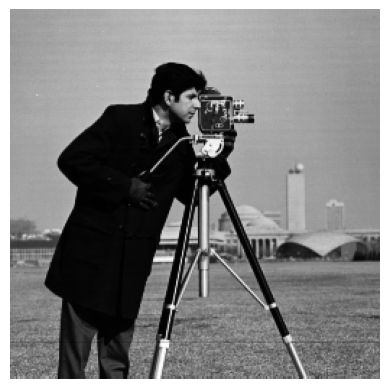

In [3]:
image = plt.imread("cameraman.png")
plt.imshow(image,cmap='gray')
plt.axis("off")  # Masquer les axes
plt.show()

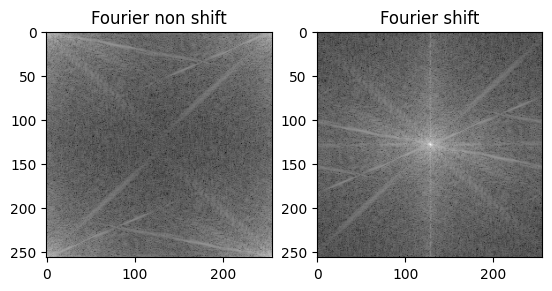

In [4]:
img_fft = numpy.fft.fft2(image)
im_fft_shift = numpy.fft.fftshift(img_fft)
plt.subplot(121)
plt.imshow(numpy.log(numpy.abs(img_fft)),cmap='gray')
plt.title("Fourier non shift")


plt.subplot(122)
plt.imshow(numpy.log(numpy.abs(im_fft_shift)),cmap='gray')
plt.title("Fourier shift")
plt.show()
# le 0 est au centre de l'image


In [5]:
# Génération du tatuouage sachant que K suit une loi normal de moyenne 0 et d'ecart type 1.
K = numpy.random.randn(1024)
print(K)
print(max(K))
print(min(K))

[-1.33562259 -0.278169   -0.69195576 ...  0.44404578 -0.36070994
  0.3987265 ]
3.0209265594404298
-3.44731454570076


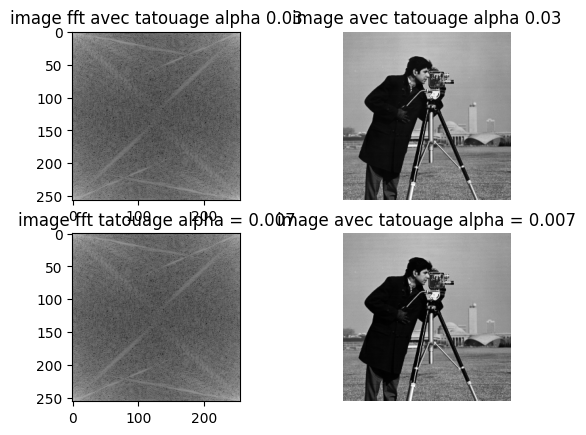

In [6]:
# prendre les 1024 plus haut coefficient de l'image de Fourier obtenue
# Faire attention à garder la symétrie hermitienne !!!!
def insertion_tatoo(im,T,alpha):
    TFD_tatouee = numpy.copy(im)
    M, N = im.shape
    K = len(T)

    ##############  essaie evec shit
    region_size = int(numpy.sqrt(K))  # Taille de la région carrée
    # start_x = (M // 2) - (region_size // 2)
    # start_y = (N // 2) - (region_size // 2)

    milieux = int(1024/2)
    T1 = T[:milieux]
    T2 = T[milieux:]

    milieux = int(1024/4)
    T1 = T[:milieux]
    T2 = T1



    #################### essaie non shift
    index = 0
    for i in range(0,int(region_size/2)):
        for j in range(0,int(region_size/2)):
            if index < len(T):
                # Ajouter le tatouage avec le coefficient de pondération
                TFD_tatouee[i, j] *= (1+alpha * T[index])
                TFD_tatouee[-i, -j] *= (1+alpha * T[index])

                TFD_tatouee[i,-j]  *= (1+alpha * T[index])
                TFD_tatouee[-i, -(-j)] *= (1+alpha * T[index])
                
                index += 1
    

    return TFD_tatouee

alpha = [0.03,0.007]
im_tatoo = insertion_tatoo(img_fft,K,alpha[0]) 
im_reconstituée = numpy.fft.ifft2(im_tatoo)
y_pred1 = numpy.real(im_reconstituée)

im_tatoo = insertion_tatoo(img_fft,K,alpha[1])
im_reconstituée = numpy.fft.ifft2((im_tatoo))
y_pred2 = numpy.real(im_reconstituée)

plt.subplot(221)
plt.imshow(numpy.log(numpy.abs(im_tatoo)),cmap='gray')
plt.title("image fft avec tatouage alpha " + str(alpha[0]))

plt.subplot(222)
plt.imshow(y_pred1,cmap='gray')
plt.axis("off")  # Masquer les axes
plt.title("image avec tatouage alpha " + str(alpha[0]))

plt.subplot(223)
plt.imshow(numpy.log(numpy.abs(im_tatoo)),cmap='gray')
plt.title("image fft tatouage alpha = " + str(alpha[1]))

plt.subplot(224)
plt.imshow(y_pred2,cmap='gray')
plt.axis("off")  # Masquer les axes
plt.title("image avec tatouage alpha = " + str(alpha[1]))
plt.show()



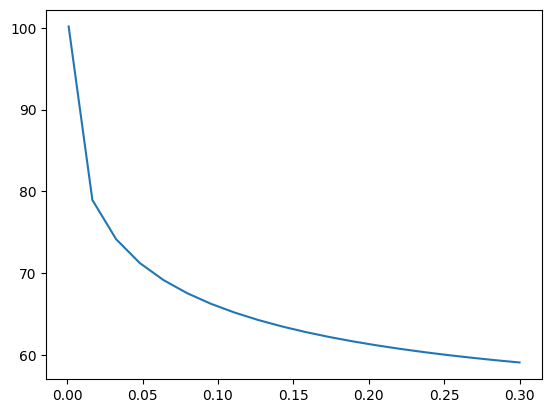

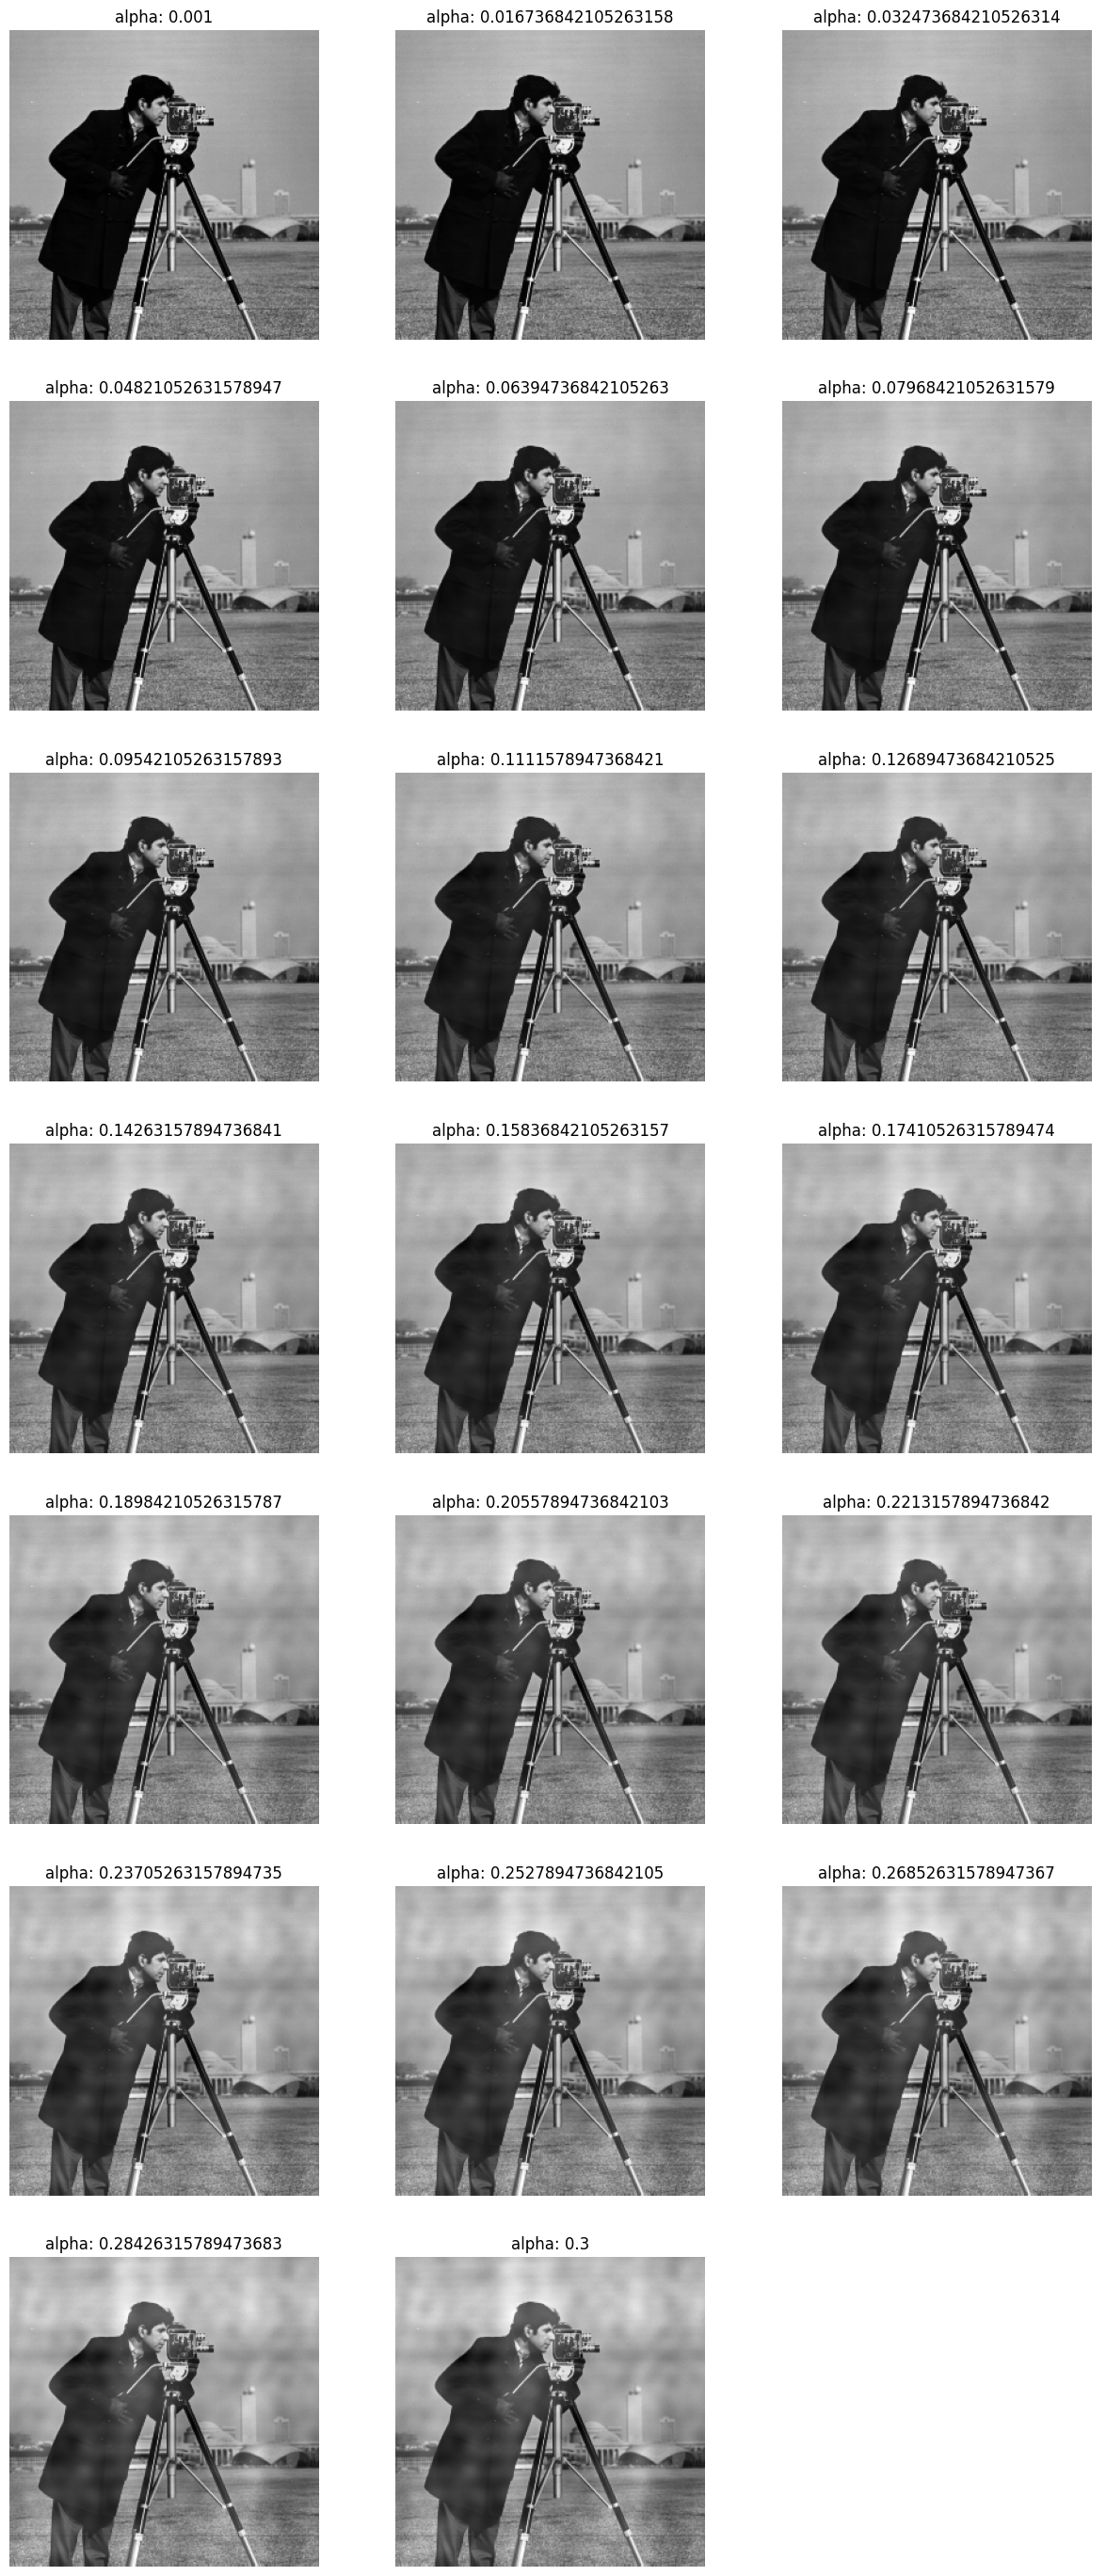

In [7]:
#TRACER DE L'EVOLUTION PSNR EN FONCTION DE ALPHA

num_alpha = 20
alpha = numpy.linspace(0.001,0.3,num_alpha)

def PNSR(im_original,im_fft,T,list_alpha) : 
    list_pnrs=[]
    y_pred = []
    y_pred_fft = []
    for i in range(len(list_alpha)):
        alpha = list_alpha[i]
        im_tatoo = insertion_tatoo(im_fft,T,alpha)

        y_pred_fft.append(im_tatoo)

        im_reconstituée = numpy.fft.ifft2(im_tatoo)
        # Si l'image doit être en valeurs réelles (pas de composantes complexes), on prend la partie réelle
        y_pred_tempo = numpy.real(im_reconstituée)

        y_pred.append(y_pred_tempo)

        list_pnrs.append(10*numpy.log10((255**2)/numpy.mean((im_original - y_pred) ** 2)))
    return list_pnrs,y_pred,y_pred_fft

list_pnrs,y_pred,y_pred_fft = PNSR(image,img_fft,K,alpha)

plt.plot(alpha, list_pnrs)

n_images = len(y_pred)
n_columns = 3  # Nombre d'images par ligne
n_rows = (n_images + n_columns - 1) // n_columns

fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 5 * n_rows))  # Créer la grille

# Aplatir les axes pour faciliter l'indexation
axes = axes.flatten()

for i in range(n_images):
    axes[i].imshow(y_pred[i], cmap='gray')  # Afficher l'image en niveaux de gris
    axes[i].set_title(f"alpha: {alpha[i]}") 
    axes[i].axis("off")  # Masquer les axes

# Si il y a des axes non utilisés (cas où n_images n'est pas un multiple de n_columns), les masquer
for i in range(n_images, len(axes)):
    axes[i].axis("off")




        

Plus alpha petit, plus on a un PNSR elevé = meillueur similitude -> faible robustesse, le tatouage trouvé après detatouage après attaque (rotation, compression,...) sera facilement le même que le vrai (calcule valeur gamma = similarité des tatouages)
Plus alpha grand, plus on a un PNSR petit = plus mauvaise smilitude, on affecte l'aspect visuelle de notre image mais meilleur robustesse, plus difficile de trouver le tatouage avec des attaques.


In [ ]:
def detection_tatouage(seuil,image_original,img_tatouage,T,alpha):
    # INVERSION DU TATOUAGE
    TFD_tatouee = (M,N)
    M, N = img_tatouage.shape
    TFD_tatouee = numpy.zeros()
    K = len(T)

    region_size = int(numpy.sqrt(K)) 

    milieux = int(1024/2)
    T1 = T[:milieux]
    T2 = T[milieux:]

    milieux = int(1024/4)
    T1 = T[:milieux]
    T2 = T1

    for i in range(0,int(region_size/2)):
        for j in range(0,int(region_size/2)):
            # Ajouter le tatouage avec le coefficient de pondération
            TFD_tatouee[i, j] = (image_original[i,j]/img_tatouage[i,j]-1)/alpha
            TFD_tatouee[-i, -j]  = (image_original[-i, -j]/img_tatouage[-i, -j]-1)/alpha

            TFD_tatouee[i,-j] = (image_original[i,-j]/img_tatouage[i,-j]-1)/alpha
            TFD_tatouee[-i, -(-j)] = (image_original[-i, -(-j)]/img_tatouage[-i, -(-j)]-1)/alpha
    
    ############## FIN TP
    return TFD_tatouee


IndentationError: expected an indented block (302838761.py, line 2)